# PyTorch Training Example with IDS-Py Framework

This notebook demonstrates a complete training workflow using the IDS-Py framework components:
- **Batch formalism**: Custom batch containers for flexible data handling
- **BaseModel**: Abstract base class for models with consistent interfaces  
- **BaseLoss**: Abstract base class for loss functions with reduction support
- **Training loops**: High-level training and evaluation loops with event handling

## Overview

We'll create a simple classification example that showcases:
1. Custom dataset and dataloader integration with Batch containers
2. Concrete model and loss implementations
3. Training loop with gradient clipping and progress tracking
4. Evaluation loop with output saving
5. Complete training pipeline with multiple epochs


---

Let's start by setting up our environment and exploring the ML workflow.

In [1]:
import sys
import os

# Add the project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# IDS-Py framework imports
from src.idspy.data.torch.batch import Features, default_collate, ensure_batch
from src.idspy.nn.torch.model.base import BaseModel, ModelOutput
from src.idspy.nn.torch.loss.base import BaseLoss
from src.idspy.nn.torch.engine.epoch import train_epoch, eval_epoch

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Create Sample Dataset and DataLoader

We'll create a synthetic classification dataset and implement a custom Dataset class that returns samples compatible with our Batch format.

In [3]:
class SyntheticDataset(Dataset):
    """
    Custom dataset that returns samples compatible with Batch format.
    Each sample is a dictionary with 'features' and 'target' keys.
    """

    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Return dictionary format compatible with Batch
        sample = {
            'features': self.features[idx],
            'targets': self.labels[idx]
        }

        return sample

# Generate synthetic classification data
print("Generating synthetic classification dataset...")
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=3,
    random_state=42
)

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Create datasets
train_dataset = SyntheticDataset(X_train, y_train)
val_dataset = SyntheticDataset(X_val, y_val)

# Create dataloaders with custom collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=default_collate,  # Use our custom collate function
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=default_collate,
    num_workers=0
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Feature dimensions: {X_train.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")

# Test a single batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch type: {type(sample_batch)}")
print(f"Features shape: {sample_batch.features.shape}")
print(f"Target shape: {sample_batch.targets.shape}")
print(f"Target values: {sample_batch.targets[:5]}")

Generating synthetic classification dataset...
Training samples: 800
Validation samples: 200
Feature dimensions: 20
Number of classes: 3

Sample batch type: <class 'src.idspy.data.torch.batch.Batch'>
Features shape: torch.Size([32, 20])
Target shape: torch.Size([32])
Target values: tensor([0, 0, 0, 2, 2])


## 3. Define Example Model

Now let's implement a concrete model class that inherits from BaseModel. This model will implement both the `forward()` and `for_loss()` methods required by the base class.

`for_loss()` method prepare arguments to be passed to the loss function, default is (output.logits, batch.target)

In [4]:
from typing import Tuple


class SimpleClassifier(BaseModel):
    """
    Simple feedforward neural network for classification.
    Demonstrates proper BaseModel implementation.
    """

    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int, dropout: float = 0.2):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        # Define layers
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # Feature extractor for latent representations
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )

        self.classifier = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x: Features) -> ModelOutput:
        """
        Forward pass implementation required by BaseModel.

        Args:
            x: Features object containing input data

        Returns:
            ModelOutput: Contains logits and optional latents/extras
        """
        # Extract latent features
        latents = self.feature_extractor(x)
        logits = self.classifier(latents)
        return ModelOutput(
            logits=logits,
            latents=latents,  # Include latent representations
        )

    def for_loss(
        self,
        output: ModelOutput,
        targets: torch.Tensor | Features,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Prepares arguments for the loss function. Default: pred=output['logits'], target=batch.target.
        Override if your model/loss requires different fields.
        """
        return output.logits, targets

# Create model instance
input_dim = X_train.shape[1]
hidden_dim = 128
num_classes = len(np.unique(y))

model = SimpleClassifier(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    dropout=0.2
)

print(f"Model created:")
print(f"  Input dimension: {input_dim}")
print(f"  Hidden dimension: {hidden_dim}")
print(f"  Number of classes: {num_classes}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test model with sample batch
model.eval()
with torch.no_grad():
    sample_output = model(sample_batch.features)
    print(f"\nModel output:")
    print(f"  Logits shape: {sample_output.logits.shape}")
    print(f"  Latents shape: {sample_output.latents.shape}")

    # Test for_loss method
    loss_inputs = model.for_loss(sample_output, sample_batch.targets)
    print(f"  Loss inputs shapes: {[t.shape for t in loss_inputs]}")

Model created:
  Input dimension: 20
  Hidden dimension: 128
  Number of classes: 3
  Total parameters: 22,278

Model output:
  Logits shape: torch.Size([32, 3])
  Latents shape: torch.Size([32, 64])
  Loss inputs shapes: [torch.Size([32, 3]), torch.Size([32])]


## 4. Define Example Loss Function

Now let's implement a concrete loss function that inherits from BaseLoss. We'll create a cross-entropy loss with optional label smoothing for classification.

`_reduce` is provided by BaseLoss and handles 'mean', 'sum', 'none'

In [5]:
class CrossEntropyLoss(BaseLoss):
    """
    Cross-entropy loss with optional label smoothing.
    Demonstrates proper BaseLoss implementation.
    """

    def __init__(self, reduction: str = "mean", label_smoothing: float = 0.0):
        super().__init__(reduction)
        self.label_smoothing = label_smoothing
        self.cross_entropy = nn.CrossEntropyLoss(
            reduction='none',  # We handle reduction ourselves
            label_smoothing=label_smoothing
        )

    def forward(self, out: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Compute cross-entropy loss.

        Args:
            out: Model predictions (logits) of shape [batch_size, num_classes]
            target: Target labels of shape [batch_size]

        Returns:
            Loss tensor (scalar or per-sample if reduction='none')
        """
        if target is None:
            raise ValueError("Target cannot be None for CrossEntropyLoss")

        # Compute raw loss (per-sample)
        loss = self.cross_entropy(out, target)

        # Apply reduction
        return self._reduce(loss)

# Create loss function
loss_fn = CrossEntropyLoss(reduction='mean', label_smoothing=0.1)

print(f"Loss function created:")
print(f"  Type: CrossEntropyLoss")
print(f"  Reduction: {loss_fn.reduction}")
print(f"  Label smoothing: {loss_fn.label_smoothing}")

# Test loss function with sample batch
model.eval()
with torch.no_grad():
    sample_output = model(sample_batch.features)
    loss_inputs = model.for_loss(sample_output, sample_batch.targets)
    sample_loss = loss_fn(*loss_inputs)
    print(f"\nSample loss: {sample_loss.item():.4f}")
    print(f"Loss tensor shape: {sample_loss.shape}")  # Should be scalar for 'mean' reduction

Loss function created:
  Type: CrossEntropyLoss
  Reduction: mean
  Label smoothing: 0.1

Sample loss: 1.1040
Loss tensor shape: torch.Size([])


## 5. Set Up Training Components

Let's configure the optimizer, device, and other training components before running the training loop.

In [6]:
# Set up device
device = torch.device('cpu')
model = model.to(device)
print(f"Using device: {device}")

# Set up optimizer
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
print(f"Optimizer: Adam(lr=0.001, weight_decay=1e-4)")

# Training hyperparameters
num_epochs = 10
clip_grad_max_norm = 1.0

print(f"Training configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Gradient clipping: {clip_grad_max_norm}")
print(f"  Batch size: {train_loader.batch_size}")
print(f"  Training batches per epoch: {len(train_loader)}")
print(f"  Validation batches per epoch: {len(val_loader)}")

# Initialize tracking lists for metrics
train_losses = []
val_losses = []
learning_rates = []
gradient_norms = []

Using device: cpu
Optimizer: Adam(lr=0.001, weight_decay=1e-4)
Training configuration:
  Epochs: 10
  Gradient clipping: 1.0
  Batch size: 32
  Training batches per epoch: 25
  Validation batches per epoch: 7


## 6. Training Loop

Now let's run the complete training loop using the engine loops from the idspy framework. This demonstrates the high-level training and evaluation functions.

In [8]:
print("Starting training...")
print("=" * 50)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 30)

    # Training phase
    train_loss, grad_norm, lr = train_epoch(
        dataloader=train_loader,
        model=model,
        device=device,
        optimizer=optimizer,
        loss_fn=loss_fn,
        clip_grad_max_norm=clip_grad_max_norm
    )

    # Validation phase
    val_loss, _, _ = eval_epoch(
        dataloader=val_loader,
        model=model,
        device=device,
        loss_fn=loss_fn,
        save_outputs=False  # We don't need outputs for now
    )

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(lr)
    if grad_norm is not None:
        gradient_norms.append(grad_norm)

    # Print epoch summary
    print(f"Epoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Learning Rate: {lr:.6f}")
    if grad_norm is not None:
        print(f"  Grad Norm: {grad_norm:.4f}")

print("\n" + "=" * 50)
print("Training completed!")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Best validation loss: {min(val_losses):.4f} (epoch {val_losses.index(min(val_losses)) + 1})")

Starting training...

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1036.87batch/s, loss=5.6421]


Epoch 1 Summary:
  Train Loss: 0.8850
  Val Loss: 0.8060
  Learning Rate: 0.001000
  Grad Norm: 0.6736

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1204.42batch/s, loss=5.1810]


Epoch 2 Summary:
  Train Loss: 0.7839
  Val Loss: 0.7401
  Learning Rate: 0.001000
  Grad Norm: 0.6024

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1047.72batch/s, loss=4.8020]


Epoch 3 Summary:
  Train Loss: 0.7167
  Val Loss: 0.6860
  Learning Rate: 0.001000
  Grad Norm: 0.6576

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1091.17batch/s, loss=4.6666]


Epoch 4 Summary:
  Train Loss: 0.6672
  Val Loss: 0.6667
  Learning Rate: 0.001000
  Grad Norm: 0.5739

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1250.43batch/s, loss=4.4544]


Epoch 5 Summary:
  Train Loss: 0.6337
  Val Loss: 0.6363
  Learning Rate: 0.001000
  Grad Norm: 0.7103

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 885.97batch/s, loss=4.3277]


Epoch 6 Summary:
  Train Loss: 0.6077
  Val Loss: 0.6182
  Learning Rate: 0.001000
  Grad Norm: 0.5219

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1022.22batch/s, loss=4.2205]


Epoch 7 Summary:
  Train Loss: 0.5847
  Val Loss: 0.6029
  Learning Rate: 0.001000
  Grad Norm: 0.4365

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1000.00batch/s, loss=4.0909]


Epoch 8 Summary:
  Train Loss: 0.5713
  Val Loss: 0.5844
  Learning Rate: 0.001000
  Grad Norm: 0.5318

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 756.49batch/s, loss=4.0032]


Epoch 9 Summary:
  Train Loss: 0.5434
  Val Loss: 0.5719
  Learning Rate: 0.001000
  Grad Norm: 0.6744

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 760.21batch/s, loss=3.9698]

Epoch 10 Summary:
  Train Loss: 0.5283
  Val Loss: 0.5671
  Learning Rate: 0.001000
  Grad Norm: 0.7197

Training completed!
Final train loss: 0.5283
Final validation loss: 0.5671
Best validation loss: 0.5671 (epoch 10)


## 7. Model Evaluation and Analysis

Let's evaluate the trained model more thoroughly and analyze its performance.

In [10]:
# Detailed evaluation with outputs saved
print("Running detailed evaluation...")
val_loss_final, _, val_outputs = eval_epoch(
    dataloader=val_loader,
    model=model,
    device=device,
    loss_fn=loss_fn,
    save_outputs=True  # Save outputs for analysis
)

# Collect predictions and targets
all_predictions = []
all_targets = []
all_logits = []

for batch, outputs in zip(val_loader, val_outputs):
    batch = ensure_batch(batch)

    # Get predictions (class with highest probability)
    predictions = torch.argmax(outputs.logits, dim=1)
    all_predictions.extend(predictions.cpu().numpy())
    all_targets.extend(batch.targets.cpu().numpy())
    all_logits.extend(outputs.logits.cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
all_logits = np.array(all_logits)

# Calculate accuracy
accuracy = (all_predictions == all_targets).mean()
print(f"Validation Accuracy: {accuracy:.4f}")

# Calculate per-class accuracy
unique_classes = np.unique(all_targets)
print("\nPer-class accuracy:")
for cls in unique_classes:
    cls_mask = all_targets == cls
    cls_accuracy = (all_predictions[cls_mask] == all_targets[cls_mask]).mean()
    print(f"  Class {cls}: {cls_accuracy:.4f} ({cls_mask.sum()} samples)")

# Calculate confidence statistics
probabilities = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
max_probabilities = probabilities.max(axis=1)
print(f"\nConfidence statistics:")
print(f"  Mean confidence: {max_probabilities.mean():.4f}")
print(f"  Min confidence: {max_probabilities.min():.4f}")
print(f"  Max confidence: {max_probabilities.max():.4f}")
print(f"  Std confidence: {max_probabilities.std():.4f}")

# Show some example predictions
print(f"\nExample predictions (first 10 samples):")
for i in range(min(10, len(all_predictions))):
    confidence = max_probabilities[i]
    correct = "✓" if all_predictions[i] == all_targets[i] else "✗"
    print(f"  {correct} Pred: {all_predictions[i]}, True: {all_targets[i]}, Conf: {confidence:.3f}")

Running detailed evaluation...


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 535.50batch/s, loss=3.9698]

Validation Accuracy: 0.8350

Per-class accuracy:
  Class 0: 0.8358 (67 samples)
  Class 1: 0.8788 (66 samples)
  Class 2: 0.7910 (67 samples)

Confidence statistics:
  Mean confidence: 0.7665
  Min confidence: 0.3975
  Max confidence: 0.9991
  Std confidence: 0.1657

Example predictions (first 10 samples):
  ✓ Pred: 0, True: 0, Conf: 0.493
  ✗ Pred: 0, True: 2, Conf: 0.545
  ✓ Pred: 1, True: 1, Conf: 0.796
  ✓ Pred: 1, True: 1, Conf: 0.868
  ✓ Pred: 2, True: 2, Conf: 0.914
  ✓ Pred: 1, True: 1, Conf: 0.517
  ✓ Pred: 2, True: 2, Conf: 0.939
  ✓ Pred: 0, True: 0, Conf: 0.884
  ✓ Pred: 0, True: 0, Conf: 0.665
  ✓ Pred: 0, True: 0, Conf: 0.500


## 8. Training Visualization

Let's visualize the training progress and model performance.

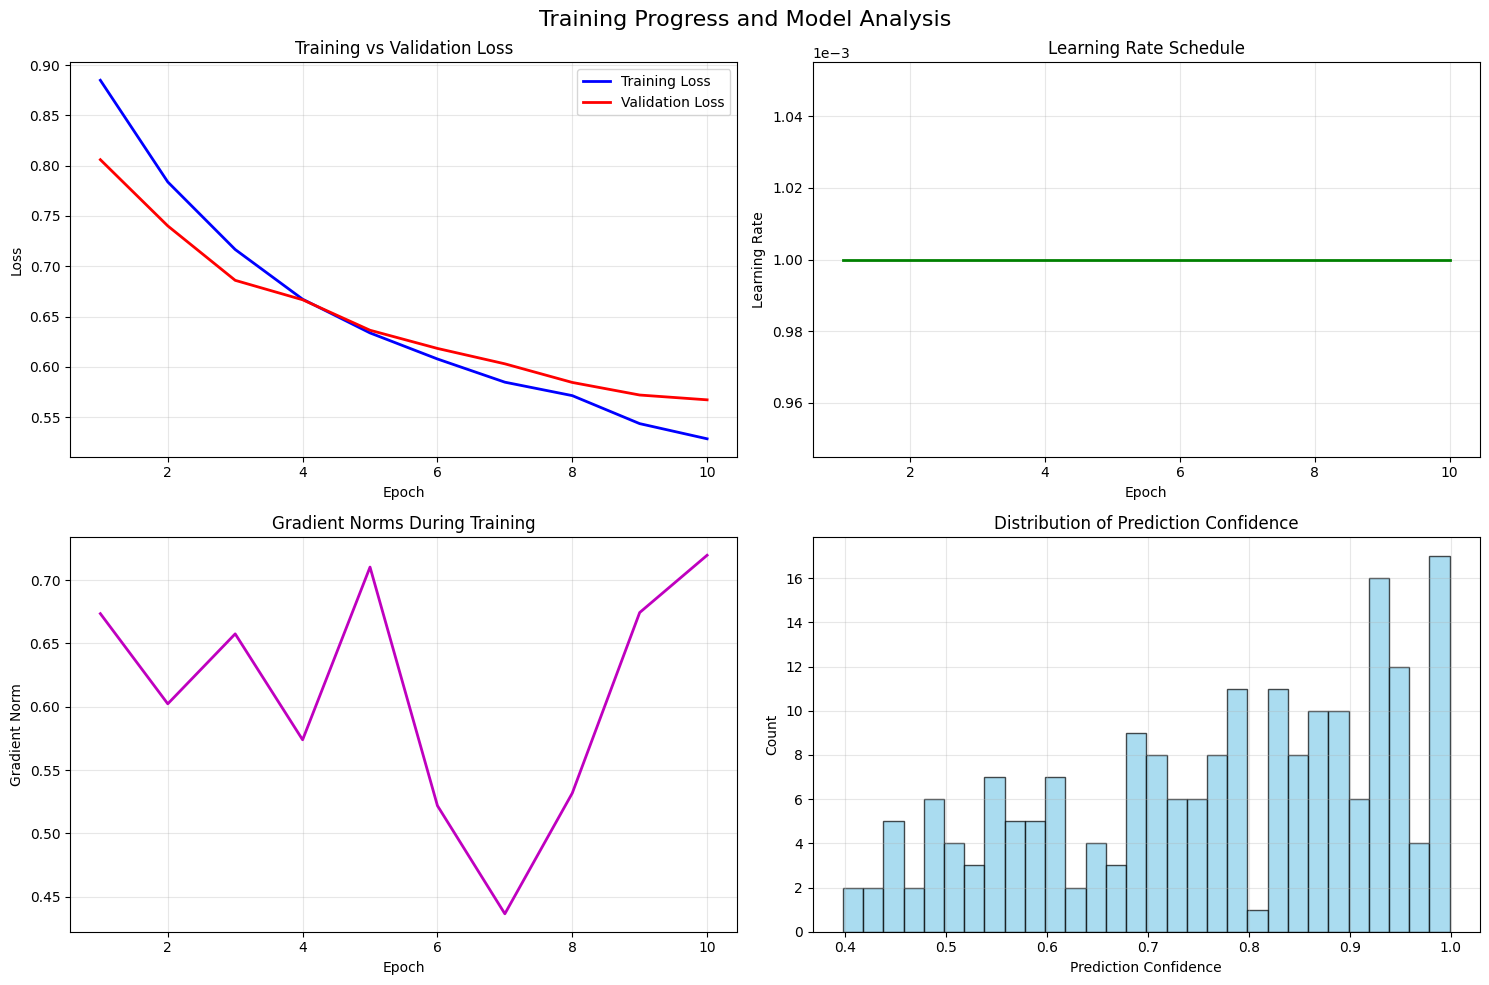


TRAINING SUMMARY
Dataset: Synthetic classification (800 train, 200 val)
Model: SimpleClassifier (22,278 parameters)
Training epochs: 10
Final training loss: 0.5283
Final validation loss: 0.5671
Best validation loss: 0.5671 (epoch 10)
Final validation accuracy: 0.8350
Average prediction confidence: 0.7665


In [11]:
# Create training visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training Progress and Model Analysis', fontsize=16)

# Plot 1: Training and Validation Loss
epochs_range = range(1, num_epochs + 1)
axes[0, 0].plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training vs Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Learning Rate Schedule
if learning_rates:
    axes[0, 1].plot(epochs_range, learning_rates, 'g-', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_title('Learning Rate Schedule')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Plot 3: Gradient Norms
if gradient_norms:
    axes[1, 0].plot(epochs_range, gradient_norms, 'm-', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Gradient Norm')
    axes[1, 0].set_title('Gradient Norms During Training')
    axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Confidence Distribution
axes[1, 1].hist(max_probabilities, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('Prediction Confidence')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Distribution of Prediction Confidence')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Dataset: Synthetic classification ({len(train_dataset)} train, {len(val_dataset)} val)")
print(f"Model: SimpleClassifier ({sum(p.numel() for p in model.parameters()):,} parameters)")
print(f"Training epochs: {num_epochs}")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Best validation loss: {min(val_losses):.4f} (epoch {val_losses.index(min(val_losses)) + 1})")
print(f"Final validation accuracy: {accuracy:.4f}")
print(f"Average prediction confidence: {max_probabilities.mean():.4f}")
print("=" * 60)

## Key Takeaways

1. **Flexible Data Handling**: The `Batch` class provides a consistent interface for model inputs
2. **BaseModel Interface**: Consistent `forward()` and `for_loss()` method signatures
3. **ModelOutput Structure**: Structured outputs with logits, latents, and optional extras
4. **BaseLoss Interface**: Consistent loss computation with flexible reduction strategies
5. **High-Level Loops**: Pre-built training and evaluation loops with progress tracking